In [ ]:
import json
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.nn import functional as F
from typing import Iterable, Tuple

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-07-06 15:15:29--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.07s   

2023-07-06 15:15:29 (16.1 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [ ]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_interval=500
eval_iters=200
n_embed = 384

max_iters = 5000
learning_rate = 3e-4

n_head = 6
n_layer = 6
dropout = 0.2

print(f"device is {device}")

device is cpu


In [ ]:
torch.manual_seed(1337)

<torch._C.Generator>

In [ ]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [ ]:
# create mappings
stoi = { ch: i for i, ch in enumerate(chars) }
itos = { i: ch for i, ch in enumerate(chars) }

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [ ]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [ ]:
class Head(nn.Module):
    """One self-attention head"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)

        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        v = self.value(x)
        out = wei @ v 
        return out 

In [ ]:
class MultiHeadAttention(nn.Module):
    """Multiple heads of self attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    

In [ ]:
class FeedForward(nn.Module):

    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)
        

In [ ]:
class Block(nn.Module):
    """One transformer block"""

    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1  = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

        
    def forward(self, x): 
        x = x + self.sa(self.ln1(x)) # The `x +` part is a skip connection
        x = x + self.ffwd(self.ln2(x)) # The `x +` part is a skip connection

        return x

In [ ]:
class TransformerLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(
            *[Block(n_embed, n_head=n_head) for _ in range(n_layer)]
        )
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        token_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, n_embed)
        x = token_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None: 
            loss = None 
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss 

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices
        for _ in range(max_new_tokens):
            # crop idx to last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get predictions
            logits, loss = self(idx_cond) # logits is (B, T, C)

            # focus only on the last time step
            logits = logits[:, -1, :] # logits is now (B, 1, C)
            probs = F.softmax(logits, dim=1)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = TransformerLanguageModel()
m.to(device)

TransformerLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=384, out_features=64, bias=False)
            (query): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwis

In [ ]:
m.load_state_dict(torch.load('./shakespeare.pt', map_location=torch.device(device)))
m.eval()

TransformerLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=384, out_features=64, bias=False)
            (query): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwis

In [ ]:
# Peek at the model size
trainable_params = [p for p in m.parameters() if p.requires_grad]
nparams = sum([np.prod(p.size()) for p in trainable_params])
nparams

10788929

In [ ]:
def str_to_tensor(s: str):
    return torch.tensor([encode(s)], dtype=torch.long, device=device)

def generate(m: TransformerLanguageModel, initial_text: str, max_new_tokens=100):
    input = str_to_tensor(initial_text)
    return decode(m.generate(input, max_new_tokens=max_new_tokens)[0].tolist())



In [ ]:
str_to_tensor('Hello')

tensor([[20, 43, 50, 50, 53]])

In [ ]:
print(generate(m, 'Hello'))

Hellowful provide the instrument to use.

CORIOLANUS:
Great of this desperate lies! Dost most war;
This m


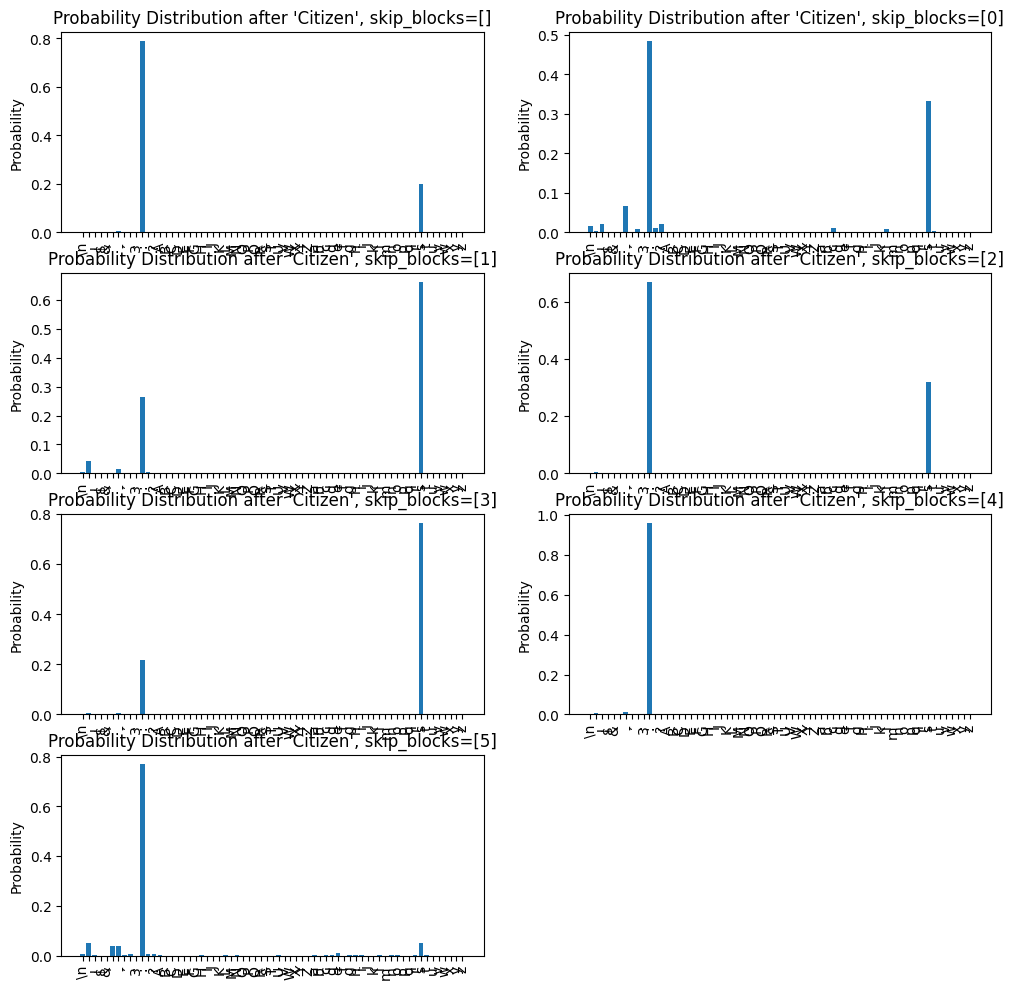

In [ ]:
def blocks(x: torch.Tensor, skip_blocks: Iterable[int] = []) -> torch.Tensor:
    """Pull apart the blocks sequential module so we can
    mess with the individual items"""
    for i, block in enumerate(m.blocks):
        if i in skip_blocks:
            continue
        x = block(x)
    return x


def get_next_probs(
    initial_str: str, skip_blocks: Iterable[int] = [],
):
  idx = str_to_tensor(initial_str)
  idx = idx[:, -block_size:]

  # Logic from the model's forward() function
  B, T = idx.shape
  token_emb = m.token_embedding_table(idx)
  pos_emb = m.position_embedding_table(torch.arange(T, device=device))  # (T, n_embed)
  x = token_emb + pos_emb
  x = blocks(x, skip_blocks=skip_blocks)  # equivalent of x = m.blocks(x)
  x = m.ln_f(x)
  logits = m.lm_head(x)

  # focus only on the last time step
  logits = logits[:, -1, :]  # logits is now (B, 1, C)
  probs = F.softmax(logits, dim=1)
  return probs 


def plot_next_probs(
    probs: np.ndarray, titles: Iterable[str], nrows: int, ncols: int, figsize: Tuple[int, int] = (12, 12)
):
    items, _ = probs.shape

    assert nrows * ncols >= items

    x_indices = np.arange(vocab_size)
    x_labels = [repr(c)[1:-1] for c in chars]

    fig = plt.figure(figsize=figsize)

    for i in range(items):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        ax.bar(x_indices, probs[i])
        ax.set_xticks(x_indices, x_labels, rotation='vertical')
        ax.set_ylabel("Probability")
        ax.set_title(titles[i])

skip_blocks_vals = [[]]
for i in range(n_layer):
    skip_blocks_vals.append([i])

s = 'Citizen'

probs = np.array([
    get_next_probs(s, skip_blocks=skip_blocks).detach().numpy().flatten()
    for skip_blocks in skip_blocks_vals
])

titles = [
    f"Probability Distribution after '{s}', skip_blocks={skip_blocks}"
    for skip_blocks in skip_blocks_vals
]

plot_next_probs(probs, titles, 4, 2)


In [ ]:
print(decode(val_data[11:100].tolist()))

Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, 


In [ ]:
# Attempt to do the logit lens thing

In [ ]:
def get_input_and_correct(data: torch.Tensor=val_data, fragment_size=16, start_idx=0):
    input = data[start_idx:start_idx+fragment_size]
    correct = data[start_idx+1:start_idx+fragment_size+1]

    return input, correct


In [ ]:
#input, correct = get_input_and_correct(val_data, start_idx=11)
input, correct = get_input_and_correct(val_data, start_idx=32)
input, correct, decode(input.tolist()), decode(correct.tolist())

(tensor([56,  1, 14, 39, 54, 58, 47, 57, 58, 39,  8,  0,  0, 14, 13, 28]),
 tensor([ 1, 14, 39, 54, 58, 47, 57, 58, 39,  8,  0,  0, 14, 13, 28, 32]),
 'r Baptista.\n\nBAP',
 ' Baptista.\n\nBAPT')

In [ ]:
def blocks(x: torch.Tensor) -> torch.Tensor:
    """Pull apart the blocks sequential module so we can
    mess with the individual items"""
    intermediates = [x.detach()]
    for block in m.blocks:
        x = block(x)
        intermediates.append(x.detach())
    return x, intermediates

def logit_lens(input: torch.Tensor):
    idx = torch.stack([input])
    idx = idx[:, -block_size:]

    # Logic from the model's forward() function
    B, T = idx.shape

    assert B == 1 # for this analysis, going to assume just 1 batch

    token_emb = m.token_embedding_table(idx)
    pos_emb = m.position_embedding_table(torch.arange(T, device=device))  # (T, n_embed)
    x = token_emb + pos_emb
    x, intermediates = blocks(x)  # equivalent of x = m.blocks(x)

    top1_preds = []
    top1_probs = []
    for x in intermediates:
        x = m.ln_f(x)
        logits = m.lm_head(x)
        top1 = torch.argmax(logits, dim=-1, keepdim=False)
        top1_list = top1[0].tolist()
        top1_chars = decode(top1_list)
        top1_preds.append(top1_chars)
        all_probs = F.softmax(logits, dim=-1)
        probs = [all_probs[0][i][j].item() for i, j in enumerate(top1_list)]
        top1_probs.append(probs)


    return top1_preds, top1_probs

logit_lens(input), decode(correct.tolist())

((['pbdgu?zt,zSDFeSE',
   'gbEyl,zt,r\nDFYUH',
   ' cettint n\n\nFURH',
   ' bettint n\n\nFERT',
   ' tacpioiig\n\nCERT',
   'etortis,a,\n\nKUPT',
   ' tortista \n\nKRRT'],
  [[0.10811267793178558,
    0.13447552919387817,
    0.24175740778446198,
    0.0955965667963028,
    0.16716203093528748,
    0.23419374227523804,
    0.4987539052963257,
    0.17296959459781647,
    0.13251550495624542,
    0.12417659908533096,
    0.3388582468032837,
    0.21581652760505676,
    0.1402878612279892,
    0.1385718286037445,
    0.14033840596675873,
    0.0966600701212883],
   [0.06667158007621765,
    0.09638173878192902,
    0.13502103090286255,
    0.11770221590995789,
    0.16857008635997772,
    0.15009218454360962,
    0.5656699538230896,
    0.3256931006908417,
    0.20084519684314728,
    0.1594742238521576,
    0.2592000365257263,
    0.12229927629232407,
    0.17312297224998474,
    0.20336508750915527,
    0.16466279327869415,
    0.09560378640890121],
   [0.09268783777952194,
    0.0883

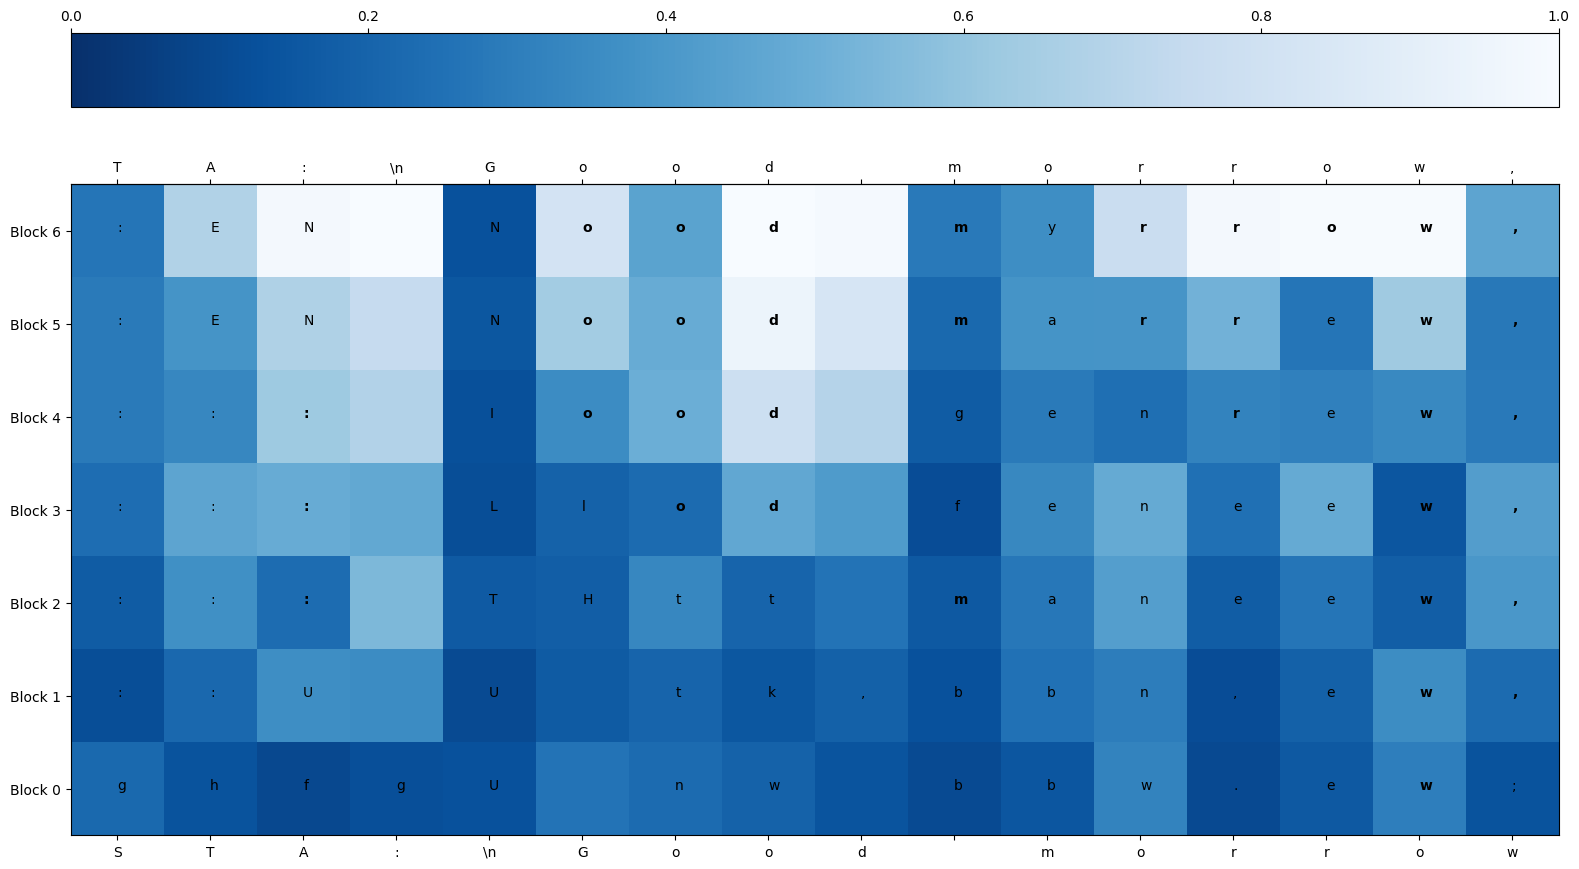

In [ ]:
def plot_logit_lens(input: torch.Tensor, correct: torch.Tensor):
    input_str, correct_str = decode(input.tolist()), decode(correct.tolist())

    top1_preds, top1_probs = logit_lens(input)

    # Reverse both results so that the last layer is at the top
    top1_preds.reverse()
    top1_probs.reverse()

    nx = len(input_str)
    ny = len(top1_preds)

    fig, ax = plt.subplots(1, 1, figsize=(1.2*nx, 20))
    im = ax.imshow(top1_probs, cmap='Blues_r')
    ax.set_xticks(range(len(input_str)))
    ax.set_xticklabels([repr(c)[1:-1] for c in input_str])

    ax.set_yticks(range(ny))
    ax.set_yticklabels([f"Block {i -1}" for i in range(ny, 0, -1)])
    
    ax_top = ax.secondary_xaxis('top')
    ax_top.set_xticks(range(len(input_str)))
    ax_top.set_xticklabels([repr(c)[1:-1] for c in correct_str])

    im.set_clim(vmin=0, vmax=1)
    plt.colorbar(im, ax=[ax], location='top')

    for y in range(ny):
        for x in range(nx):
            fontweight = 'bold' if top1_preds[y][x] == correct_str[x] else None
            plt.text(x, y, top1_preds[y][x], fontweight=fontweight)


input, correct = get_input_and_correct(val_data, start_idx=50)
plot_logit_lens(input, correct)

In [ ]:
idx = torch.stack([input])
idx = idx[:, -block_size:]

# Logic from the model's forward() function
B, T = idx.shape

assert B == 1 # for this analysis, going to assume just 1 batch

token_emb = m.token_embedding_table(idx)
pos_emb = m.position_embedding_table(torch.arange(T, device=device))  # (T, n_embed)
x = token_emb + pos_emb
x, intermediates = blocks(x) 


x = m.ln_f(x)
logits = m.lm_head(x)
top1 = torch.argmax(logits, dim=-1, keepdim=False)
top1

tensor([[ 1, 58, 53, 56, 58, 47, 57, 58, 39,  1,  0,  0, 23, 30, 30, 32]])

In [ ]:
# End of logit lens experiment

In [ ]:
# start trying to project singular vectors


In [ ]:
n_directions = 20
k = 5
block_idx = 3

w_in_matrix = m.blocks[block_idx].ffwd.net[0].weight.data
U, S, V = torch.linalg.svd(w_in_matrix, full_matrices=False)

V = V[:n_directions, :]
V = m.ln_f(V)
logits = m.lm_head(V)
logits.size()
topk = torch.topk(logits, k=k, dim=1, sorted=True).indices

results = [
    decode(topk[i, :].tolist())
    for i in range(n_directions)
]
results

['st ni',
 '.:;!,',
 'oaiez',
 ' e\ngu',
 'CltcN',
 ",' e;",
 "htH'l",
 'kdwFt',
 'hilwy',
 "oi'au",
 'RSMEI',
 'nmuvb',
 'dmyGb',
 'twTau',
 'kpser',
 'dhlfg',
 'LhFPp',
 'qtgnm',
 "emfs'",
 'dwFvb']

In [ ]:
# find i such that sum(S[:i]) >= 0.99*sum(S)

i=375
sum(S[:i]) / sum(S)

# So you need 375/384 directions, hmmm.

tensor(0.9908)

In [ ]:
def topk_tokens(logits: torch.Tensor, k: int=5):
    """Returns the top k tokens from a tensor of logits. 
    
    Parameters
    ----------
    logits:
        Tensor containing logits. Dimension should be (N, vocab_size). 
    
    k:
        How many tokens to return
    
    Returns
    -------
    Iterable[str]
        An iterable of N k-length strings, containing the top tokens in order.
    """
    n, _ = logits.shape 

    topk = torch.topk(logits, k=k, dim=1, sorted=True).indices

    results = [
        decode(topk[i, :].tolist())
        for i in range(n)
    ]
    return results


In [ ]:
# singular vectors for the MLP layer
def singular_vectors_mlp(m: TransformerLanguageModel, block_idx: int=0, k: int=5, n_directions: int=20):
    w_in_matrix = m.blocks[block_idx].ffwd.net[0].weight.data
    U, S, V = torch.linalg.svd(w_in_matrix, full_matrices=False)

    V = V[:n_directions, :]
    V = m.ln_f(V)
    logits = m.lm_head(V)

    return topk_tokens(logits, k=k)

singular_vectors_mlp(m, block_idx=3, k=15, n_directions=20)

['st niledrca,mo:',
 ".:;!,?-\n'X3$s&S",
 'oaiezyucxYOAbEg',
 " e\ngu-yO.i';RoB",
 'CltcNOLJGyAKTRB',
 ",' e;!vydaw.-?:",
 "htH'lINAkUDsnw,",
 'kdwFtgObuDyVWMj',
 "hilwyetrHs ,c'!",
 "oi'auryELnhJNl.",
 'RSMEIi:mGHBpNAJ',
 "nmuvbptzgMfrcl'",
 "dmyGbILRrilWD'g",
 "twTauCRo, cIr'N",
 'kpsernodDcmSThb',
 'dhlfgVceFkBnpCm',
 "LhFPpSNIT'VJKCO",
 'qtgnmxsrcRBGadX',
 "emfs'oz3n!xUi;,",
 'dwFvbSYHpTC\nWjI']

In [ ]:
# singular vectors for OV circuit

def singular_vectors_OV(m: TransformerLanguageModel,, head_idx: int=3, k: int=5, n_directions: int=20):
    # Get the V matrix from the block/head
    v = m.blocks[block_idx].sa.heads[head_idx].value.weight.data.detach() # n_embed x head_size

    # Get the O (projection) matrix from the block
    o = m.blocks[block_idx].sa.proj # n_embed x n_embed
    o_weight = o.weight.data.detach() # n_embed x n_embed
    o_bias = o.bias.data.detach()

    # Get the subset of the proj matrix that applies to this head
    o_weight_head = o_weight.reshape(n_embed, n_head, n_embed // n_head)[:, head_idx, :]
    o_weight_head.shape, v.shape

    # Do W_O @ V + bias
    out = o_weight_head @ v + o_bias

    # Do the SVD business
    U, S, V = torch.linalg.svd(out, full_matrices=False)

    V = V[:n_directions, :]
    V = m.blocks[block_idx].ln2(V) # Apply layer norm from the block

    logits = m.lm_head(m.ln_f(V))

    return topk_tokens(logits, k=k)

singular_vectors_OV(m, block_idx=5, head_idx=3, k=5, n_directions=20)


['Jzbc3',
 'o\nl r',
 'Q;, x',
 'xvuk3',
 '-\nNl ',
 'sprvg',
 'imqJ ',
 "hf'v?",
 'lxvs!',
 'SRFBD',
 'KHmCl',
 'ihWwc',
 'nel:t',
 'otedg',
 "etuc'",
 'OZISE',
 'dGDso',
 ':?wrm',
 'mnf s',
 'hkdes']

In [ ]:
def df_heads(m: TransformerLanguageModel, block_idx: int=0):
    data = [
        singular_vectors_OV(m, block_idx=block_idx, head_idx=h, k=10, n_directions=20)
        for h in range(n_head)
    ]
    return pd.DataFrame(data, index=[f'Head {h}' for h in range(n_head)])

In [ ]:
df_heads(m, block_idx=0)

,Head 0,Head 1,Head 2,Head 3,Head 4,Head 5
0,"sYNnrl.U,:",qvaVduiPXm,qvaVduiPCX,qvaVduiPXC,qvaVduiPXC,qvaVduiPCm
1,iLRoEMrTtG,iLmoAztRhe,"aeiy\n!-o.,",trngblcvIk,RimGoLzArK,iLrRomzutG
2,:TSoetUsMi,nXPRcNfgk?,AobsmeUBdr,PaImM.ZKCA,ye\ni-'o. !,wBtbczdrlg
3,omde!zV-as,b'rtnvzwsl,LRhyqGHNEk,zemwbI$GOp,":tls p.,;-",QX$'Zkzdyj
4,eiy \nE!I.-,yuoaKe&i\nH,bgqr$V?apf,oeaniusp r,OoIuYptmaz,LH.ygui?aG
5,'leai-:&Uz,Vpyj'fvhai,e'sEiaco-g,":;,\n.!? -o","duftXLv$m,",siuAaUpmkh
6,"daoe, mis-",ryPIiwebJG,"'ly,u?!med",'Kydear\nJz,lAZpHQitXg,ftysdiabmp
7,"lri uft,:E",lhtgpvxbya,JPNYFWpxSB,sz'rIwuoFn,"-\n,d.!;k A",":;,vKa.e?&"
8,telnuriaTy,"'-ps!vd, o",ptizQaYMlG,Xqcw\nu-v z,"iT ,n?.Jtg","l ?,a.-:;i"
9,LoVrBNa&ZP,d-\nGxncus$,VyI'gl&ATB,ie-'wnuh?,":eNdh!,A'U","svSlid:Me,"


In [ ]:
df_heads(m, block_idx=0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Head 0,"sYNnrl.U,:",iLRoEMrTtG,:TSoetUsMi,omde!zV-as,eiy \nE!I.-,'leai-:&Uz,"daoe, mis-","lri uft,:E",telnuriaTy,LoVrBNa&ZP,tvSOiLdaos,ndyfoievuS,",rysflwd'",RFfMbtvgVK,"g s?i,oFe;",:Isua!eCAb,dEBsmADCRM,eliC\nkcvI',DLyJu!QBN\n,fygs urPD-
Head 1,qvaVduiPXm,iLmoAztRhe,nXPRcNfgk?,b'rtnvzwsl,yuoaKe&i\nH,Vpyj'fvhai,ryPIiwebJG,lhtgpvxbya,"'-ps!vd, o",d-\nGxncus$,"w\nYm,hTWs","zgPNp,K:Gn",zsGwPxBRAC,ruelaoiy.?,VMAoyBhWDk,"hbzn,u!g;?",abhxenor!i,aoKTlkeIrY,"-z:m\n;,st",mybvkidt's
Head 2,qvaVduiPCX,"aeiy\n!-o.,",AobsmeUBdr,LRhyqGHNEk,bgqr$V?apf,e'sEiaco-g,"'ly,u?!med",JPNYFWpxSB,ptizQaYMlG,VyI'gl&ATB,"F l,ri\n.'y",ujoEVlOCUq,MhZCHiTjIA,lqTsYxNGBE,dqbmkyjeva,",;:!. wIlO",IpiKEoubjy,HlyiBICgo,XWzFaQpkMN,"oal e-u,iy"
Head 3,qvaVduiPXC,trngblcvIk,PaImM.ZKCA,zemwbI$GOp,oeaniusp r,":;,\n.!? -o",'Kydear\nJz,sz'rIwuoFn,Xqcw\nu-v z,ie-'wnuh?,tRond: v'l,ACygzwtfiU,ybipmuktMU,C-tMlHszLT,lOtJ zFmRs,lyxurJRNHX,meo:;XiwA.,noE'wgfjst,"lsi.;e,' f",es ialrcth
Head 4,qvaVduiPXC,RimGoLzArK,ye\ni-'o. !,":tls p.,;-",OoIuYptmaz,"duftXLv$m,",lAZpHQitXg,"-\n,d.!;k A","iT ,n?.Jtg",":eNdh!,A'U",yek'?JEQWM,"xa,nlosv'r",yeh-biasBE,gtDqcYkpPm,C-kTdKgF;V,nlheas'yi,S!c:HCtDL&,iyrRbauGl,StX'qsTNMJ,"ery!h.im,t"
Head 5,qvaVduiPCm,iLrRomzutG,wBtbczdrlg,QX$'Zkzdyj,LH.ygui?aG,siuAaUpmkh,ftysdiabmp,":;,vKa.e?&","l ?,a.-:;i","svSlid:Me,",camyekrUt,-tnscOhb g,"tiseT'gl,",yIrHEpuMKl,\nIGD:Liy3Y,:Yjiek-bcm,"'dkts, .fh","e\n?!y i,.;",gbtp' nSTd,inwRherazo


In [ ]:
x.reshape(6, 2, 3)[:, 0, :]

tensor([[ 0,  1,  2],
        [ 6,  7,  8],
        [12, 13, 14],
        [18, 19, 20],
        [24, 25, 26],
        [30, 31, 32]])

In [ ]:
# end trying to project singular vectors

In [ ]:
def final_embedding_for_char(
    target_char: str, 
    lm_head_weights: torch.Tensor,
    lm_head_bias: torch.Tensor, 
    learning_rate: float = 3e-4,
    max_iters: int = 50000,
    device: str = device,
) -> torch.Tensor:
    """Given a character, learns the embedding that,
    when given as input to the `lm_head` linear layer at
    the end of the transformer, produces the logits select
    that character with probability almost 1."""
    assert len(target_char) == 1
    target = torch.tensor(encode(target_char)[0], device=device)

    # Create the lm_head layer with the given weights and bias.
    lm_head = nn.Linear(n_embed, vocab_size)
    with torch.no_grad():
        lm_head.weight = nn.Parameter(lm_head_weights.detach())
        lm_head.bias = nn.Parameter(lm_head_bias.detach())
    lm_head.to(device)

    lsfm = nn.LogSoftmax(dim=-1)
    lsfm.to(device)

    x = torch.nn.Parameter(torch.randn(n_embed), requires_grad=True).to(device)

    optimizer = torch.optim.AdamW([x], lr=learning_rate)
    eval_iters = max_iters // 10  

    print(f"Optimizing embedding for {repr(target_char)}")
    for step in range(max_iters):
        yhat = lsfm(lm_head(x))
        loss = F.nll_loss(yhat, target)

        if torch.isclose(loss, torch.tensor(0, dtype=loss.dtype, device=device)).item():
            print(f"ending training at step {step}: loss {loss.item():.4f}")
            break 

        if step % eval_iters == 0:
            print(f"step {step}: loss {loss.item():.4f}")

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    return x.data.detach(), loss

In [ ]:
# Create a dictionary of the embeddings learned for each character
char_to_embedding = {
    c: final_embedding_for_char(
        target_char=c, 
        lm_head_weights=m.lm_head.weight.data.detach(),
        lm_head_bias=m.lm_head.bias.data.detach(),
    )[0]
    for c in chars
}

Optimizing embedding for '\n'
step 0: loss 5.6003
step 5000: loss 0.0161
step 10000: loss 0.0012
step 15000: loss 0.0001
step 20000: loss 0.0000
step 25000: loss 0.0000
ending training at step 29156: loss 0.0000
Optimizing embedding for ' '
step 0: loss 3.2772
step 5000: loss 0.0124
step 10000: loss 0.0009
step 15000: loss 0.0001
step 20000: loss 0.0000
step 25000: loss 0.0000
ending training at step 27694: loss 0.0000
Optimizing embedding for '!'
step 0: loss 5.5344
step 5000: loss 0.0145
step 10000: loss 0.0011
step 15000: loss 0.0001
step 20000: loss 0.0000
step 25000: loss 0.0000
ending training at step 27042: loss 0.0000
Optimizing embedding for '$'
step 0: loss 4.9751
step 5000: loss 0.0180
step 10000: loss 0.0014
step 15000: loss 0.0001
step 20000: loss 0.0000
step 25000: loss 0.0000
step 30000: loss 0.0000
ending training at step 30098: loss 0.0000
Optimizing embedding for '&'
step 0: loss 4.8747
step 5000: loss 0.0220
step 10000: loss 0.0016
step 15000: loss 0.0001
step 20000:

In [ ]:
# Save char to embedding as json file
c2e_list = {
    c: embed.tolist()
    for c, embed in char_to_embedding.items()
}
Path('./char_to_embed.json').write_text(json.dumps(c2e_list, indent=2))

In [ ]:
# Load char to embedding from json file

c2e_json = json.loads(Path('./char_to_embed.json').read_text())
c2e_loaded = {
    c: torch.tensor(emb_list, dtype=torch.float32, device=device)
    for c, emb_list in c2e_json.items()
}

In [ ]:
# assert that loaded version is the same as the learned one
for c in char_to_embedding.keys():
    if not torch.allclose(char_to_embedding[c], c2e_loaded[c]):
        print(f"value for {c} is not close")

In [ ]:
char_to_embedding = c2e_loaded

In [ ]:
target = torch.tensor(encode('s')[0])
ans = F.one_hot(target, num_classes=vocab_size)
F.nll_loss(torch.log(ans.float()), target).item()


0.0